In [ ]:
# %matplotlib widget

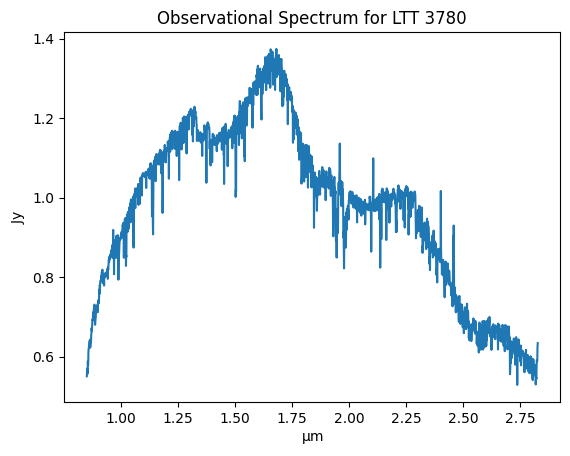

[SPECTRUM COMPONENT ANALYSER] : reading in hdf5
[SPECTRUM COMPONENT ANALYSER] : finished reading in hdf5


In [1]:
# for now, just request a random composite spectrum from facula_and_spot_creator
# and try to decompose it - aka can we regenerate the w's

# eventually can read in external data or some training data from a large hdf5 file etc

from itertools import product
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
quantity_support()
from tqdm import tqdm
import astropy.units as u
import os

from spectrum_component_analyser.internals.spectrum import spectrum
from spectrum_component_analyser.internals.readers import read_JWST_fits
from spectrum_component_analyser.internals.spectral_grid import spectral_grid
from spectrum_component_analyser.helper import calc_result, get_optimality, plot_nicely, get_main_components

external_spectrum_path = Path("../../observed_spectra/MAST_2025-10-26T11_57_04.058Z - LTT-3780/MAST_2025-10-26T11_57_04.058Z/JWST/jw03557004001_04101_00001-seg001_nis_x1dints.fits")
script_dir = os.getcwd()
wavelength_grid_absolute_path = (script_dir / external_spectrum_path).resolve()

spectrum_to_decompose : spectrum = read_JWST_fits(wavelength_grid_absolute_path, INTEGRATION_INDEX=100, name="LTT 3780")
spectrum_to_decompose.plot()

mask = np.isfinite(spectrum_to_decompose.Fluxes)

spectrum_to_decompose = spectrum_to_decompose[mask]

print("[SPECTRUM COMPONENT ANALYSER] : reading in hdf5")
spectral_grid_relative_path = Path("../../spectral_grids/JWST_convolved_spectral_grid.hdf5")
spectral_grid_absolute_path = (script_dir / spectral_grid_relative_path).resolve()
spec_grid : spectral_grid = spectral_grid.from_hdf5(absolute_path=spectral_grid_absolute_path)
lookup_table = spec_grid.to_lookup_table()
print("[SPECTRUM COMPONENT ANALYSER] : finished reading in hdf5")

In [2]:
all_parameters = list(product(spec_grid.T_effs, spec_grid.FeHs, [5 * u.dimensionless_unscaled]))

total_number_of_components = len(all_parameters)

A, result = calc_result(all_parameters, lookup_table, spec_grid=spec_grid, spectrum_to_decompose=spectrum_to_decompose, mask=mask, total_number_of_components=total_number_of_components)
print(f"residual MSE = {get_optimality(A, result, spectrum_to_decompose)}")

Appending values to A matrix...: 100%|██████████| 162/162 [00:00<00:00, 1152.68it/s]


minimising
   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         8.3244e+06                                    4.12e+05    
       1         2.0587e+06      6.27e+06       3.32e+00       1.03e+05    
       2         5.0361e+05      1.56e+06       1.66e+00       2.58e+04    
       3         1.2053e+05      3.83e+05       8.29e-01       6.44e+03    
       4         2.7601e+04      9.29e+04       4.14e-01       1.61e+03    
       5         5.7789e+03      2.18e+04       2.06e-01       4.00e+02    
       6         1.0108e+03      4.77e+03       1.01e-01       9.81e+01    
       7         1.3096e+02      8.80e+02       4.72e-02       2.30e+01    
       8         2.0929e+01      1.10e+02       1.77e-02       4.99e+00    
       9         7.7223e+00      1.32e+01       1.30e-02       1.71e+01    
      10         7.6159e+00      1.06e-01       6.52e-03       3.93e+00    
      11         5.6466e+00      1.97e+00       6.15e-03       5.42e+01    
 

TypeError: spectrum.__init__() got an unexpected keyword argument 'normalise_flux'

In [ ]:
hash_map = plot_nicely(A, result, all_parameters, spec_grid, spectrum_to_decompose)

In [ ]:
# now lets re-run that, but with only the top few components and see if the fit is better

# prolly want a new class for this lmao
# or could be a list of phoenix spectra; maybe that would help the above code be a bit neater too

ns = np.arange(1, 20, 1)
optimalities = np.array([])

for number_of_components_to_keep in tqdm(ns):
    
    main_components = get_main_components(hash_map, number_of_components_to_keep)

    A_restricted, result_restricted = calc_result(main_components,
                                                  lookup_table,
                                                  spectrum_to_decompose=spectrum_to_decompose,
                                                  spec_grid = spec_grid,
                                                  mask=mask,
                                                  total_number_of_components=len(main_components),
                                                  verbose=False)

    optimalities = np.append(optimalities, get_optimality(A_restricted, result_restricted, spectrum_to_decompose)[0])

# plt.clf()
plt.figure(figsize=(10,4))
plt.semilogy(ns, optimalities)
plt.semilogy(ns, [get_optimality(A, result, spectrum_to_decompose)[0]] * len(ns), linestyle="dashed", label="optimality when using all PHOENIX spectra")
plt.xticks(ns)
plt.grid()
plt.legend()
plt.xlabel("number of components considered")
plt.ylabel("optimality")  #of matrix minimisation method (lower is more optimal)
plt.title(f"Optimality vs Number of Components Used")
plt.show()

In [ ]:
main_components = get_main_components(hash_map, 7)

shifted_lookup_table = {k: v.copy() for k, v in lookup_table.items()}

for key, flux in shifted_lookup_table.items():
    flux[:] = np.roll(flux, 0) # need the [:] for in place modification i.e. to change the reference

A_restricted, result_restricted = calc_result(main_components,
                                              shifted_lookup_table,
                                              spectrum_to_decompose=spectrum_to_decompose,
                                              spec_grid=spec_grid,
                                              mask=mask,
                                              total_number_of_components=len(main_components),
                                              verbose=False)

print(f"Residual MSE = {get_optimality(A_restricted, result_restricted, spectrum_to_decompose)[0]}")

_ = plot_nicely(A_restricted, result_restricted, main_components, spec_grid, spectrum_to_decompose)

In [ ]:
# can try another meta-optimiser: shift the spectrum between [-20,+20] or smthn resolutions to the left & right
# there might be some small zero error on the phoenix grid or smthn (I wouldn't be suprised) - this would help check for that

# from experimenting: no rolling is best
main_comps = get_main_components(hash_map, 10)

optimalities = []

# independent copy - we dont want the shift to affect the original lookup_table
shifted_lookup_table = {k: v.copy() for k, v in lookup_table.items()}

shifts = np.arange(-10,10,1)

for key, flux in shifted_lookup_table.items():
    flux[:] = np.roll(flux, np.min(shifts)) # need the [:] for in place modification i.e. to change the reference

A, result = calc_result(main_comps,
                        shifted_lookup_table,
                        spectrum_to_decompose=spectrum_to_decompose,
                        spec_grid=spec_grid,
                        mask=mask,
                        total_number_of_components=len(main_comps),
                        verbose=False)

optimalities.append(get_optimality(A, result, spectrum_to_decompose)[0])

positive_shifts = shifts + np.abs(np.min(shifts))

for shift in tqdm(positive_shifts[0:-1]):
    for key, flux in shifted_lookup_table.items():
        flux[:] = np.roll(flux, 1) # need the [:] for in place modification i.e. to change the reference
    A, result = calc_result(main_comps,
                            shifted_lookup_table,
                            spectrum_to_decompose=spectrum_to_decompose,
                            spec_grid=spec_grid,
                            mask=mask,
                            total_number_of_components=len(main_comps),
                            verbose=False)
    optimalities.append(get_optimality(A, result, spectrum_to_decompose)[0])

    # plot_nicely(A, result, main_comps)

plt.clf()
plt.semilogy(shifts, optimalities)
plt.xlabel("roll / shift")
plt.ylabel("optimality of solution (using top 10 best components only)")
plt.show()

# now we can fit in sections too

# can also interpolate in different ways

# also can visualise other spectra; see what works

# also can use other spectra from lalitha